In [1]:
%load_ext autoreload
%autoreload 2

# Visualise Ruggedness from generated circuits - exploratory

In [ ]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.evolution import calculate_ruggedness_core
from evoscaper.utils.math import arrayise, make_flat_triangle, make_batch_symmetrical_matrices, make_sequence_from_symmetrical
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.visualise import make_sort_hue
from evoscaper.utils.visualise import create_network_inset, make_nx_weights, vis_sampled_histplot
from evoscaper.run.ruggedness import create_perturbations, get_perturbations
from common import load_stitch_analytics, norm_rugg, load_rugg, make_df_rugg, load_stitch_ys
import matplotlib.gridspec
from scipy.cluster.hierarchy import fcluster

from functools import partial
import itertools
import os
import json
import sys
import numpy as np
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.2)
custom_palette = sns.blend_palette(
    ['#ff9f9b', '#ffb482', '#fffea3', '#c1f6b8', '#a0e7e0', '#b9d3ee', '#d6a4ef', '#ff77a7'], n_colors=9)

# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

2025-07-30 13:12:24.487403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753881144.498699  358683 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753881144.502161  358683 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753881144.515350  358683 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753881144.515357  358683 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753881144.515358  358683 computation_placer.cc:177] computation placer alr

[CpuDevice(id=0)]

# Load

In [3]:
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_03_25__12_53_19')
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_02__16_52_25')
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_03__11_00_50')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_03__11_20_36')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_04__14_00_16')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_04__14_18_54')  # testing
dir_src_rugg = os.path.join('data', 'ruggedness', '2025_07_05__15_10_09')

config_rugg = load_json_as_dict(os.path.join(dir_src_rugg, 'config.json'))
fn_df_hpos_loaded = config_rugg['fn_df_hpos_loaded'].replace('notebooks/', '')
hpos = pd.Series(load_json_as_dict(fn_df_hpos_loaded))
dir_src_nn = os.path.dirname(fn_df_hpos_loaded)
fn_saves = os.path.join(dir_src_nn, [i for i in os.listdir(
    dir_src_nn) if i.startswith('saves')][0])
idx_output = -1

config = {'fn_saves': fn_saves,
          'dir_src_rugg': dir_src_rugg}
top_write_dir = os.path.join(
    'data', '20_visualise_rugged_explore', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)
with open(os.path.join(top_write_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print('top_write_dir:', top_write_dir)

top_write_dir: data/20_visualise_rugged_explore/2025_07_30__13_12_26


In [4]:
saves_loaded = load_json_as_dict(fn_saves)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

params = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
params = arrayise(params)

config_bio = load_json_as_dict(config_dataset.filenames_verify_config)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Analytics & Circuits

In [5]:
analytics_rugg = load_stitch_analytics(dir_src_rugg, last_idx=idx_output)

In [6]:
config_rugg

{'eps_perc': -0.01,
 'x_type': 'energies',
 'signal_species': 'RNA_0',
 'resimulate_analytics': True,
 'perturb_once': True,
 'n_perturbs': 1,
 'analytic': 'Log sensitivity',
 'eval_batch_size': 100000,
 'eval_n_to_sample': 1500000,
 'eval_cond_min': [-0.1, -0.1],
 'eval_cond_max': [1.1, 1.1],
 'eval_n_categories': 13,
 'fn_saves': None,
 'fn_df_hpos_loaded': 'notebooks/data/01_cvae/2025_03_25__12_04_01/hpos_all.json',
 'fn_ds': None,
 'fn_circuits': None,
 'fn_simulation_settings': 'notebooks/configs/cvae_multi/simulation_settings2.json',
 'filenames_verify_config': 'data/raw/summarise_simulation/2024_11_27_145142/ensemble_config.json'}

In [7]:
all_fake_circuits = np.load(os.path.join(
    dir_src_rugg, 'all_fake_circuits.npy'))
n_species = all_fake_circuits.shape[-1]

all_sampled_cond = np.load(os.path.join(
    dir_src_rugg, 'sampled_cond', 'sampled_cond_0.npy'))

from evoscaper.utils.math import arrayise, make_flat_triangle, make_batch_symmetrical_matrices, make_sequence_from_symmetrical
from evoscaper.run.ruggedness import create_perturbations, get_perturbations
if config_rugg['perturb_once']:
    eps = np.load('data/ruggedness/2025_07_05__15_10_09/batch_104/eps.npy')
    # all_fake_circuits = jax.vmap(
    #     partial(create_perturbations, eps=eps))(all_fake_circuits)
    n_samples = all_fake_circuits.shape[0]
    all_fake_circuits, eps, n_perturbs = get_perturbations(
        make_flat_triangle(all_fake_circuits), config_rugg['eps_perc'], n_samples, config_rugg['n_perturbs'], config_rugg['resimulate_analytics'], config_rugg['perturb_once'])
    all_fake_circuits = make_batch_symmetrical_matrices(all_fake_circuits.reshape(-1, all_fake_circuits.shape[-1]), side_length=n_species)

# Load ys from batches
# fn_ys = os.path.join(dir_src_rugg, 'ys.npy')
# if os.path.exists(fn_ys):
#     ys = np.load(fn_ys)
#     ts = np.load(os.path.join(dir_src_rugg, 'ts.npy'))
# else:
#     batch_dirs = [c for c in os.listdir(dir_src_rugg) if c.startswith('batch')]
#     batch_dirs.sort(key=lambda x: int(x.split('_')[1]))
#     for b in batch_dirs:
#         ys_i = np.load(os.path.join(dir_src_rugg, b, 'ys.npy'))
#         ts = np.load(os.path.join(dir_src_rugg, b, 'ts.npy'))
#         if 'ys' not in locals():
#             ys = ys_i
#             ts_all = ts
#         else:
#             ys = np.concatenate((ys, ys_i), axis=0)
#             ts_all = np.concatenate((ts_all, ts), axis=0)

#     np.save(fn_ys, ys)

# ys_out = ys[..., idx_output]

In [ ]:
n_interactions = make_flat_triangle(all_fake_circuits).shape[-1]
n_perturbs = config_bio['n_perturbs'] if not config_rugg['perturb_once'] else n_interactions + config_rugg['resimulate_analytics']


ys_out, ts = load_stitch_ys(dir_src_rugg, idx_output, len(all_fake_circuits))

In [12]:
assert len(ys_out) == len(all_fake_circuits), 'Probably stitched ys together wrong'

## Calculate Ruggedness

In [15]:
for k in analytics_rugg.keys(): 
    analytics_rugg[k] = analytics_rugg[k].reshape(
        -1, n_perturbs, analytics_rugg[k].shape[-1] if analytics_rugg[k].ndim > 1 else 1)

In [16]:
n_samples = all_fake_circuits.reshape(-1, n_perturbs, *all_fake_circuits.shape[1:]).shape[0]
n_interactions = make_flat_triangle(all_fake_circuits[0]).shape[-1]
n_perturbs = n_interactions + config_rugg['resimulate_analytics']
eps = config_rugg['eps_perc'] * np.abs(all_fake_circuits).max()

ruggedness = {}
for analytic in analytics_rugg.keys():
    ruggedness[analytic] = calculate_ruggedness_core(analytics_rugg, None, analytic,
                                                     config_rugg['resimulate_analytics'], n_samples, n_perturbs, eps)

if config_rugg['resimulate_analytics']:
    # n_max = n_samples * n_perturbs
    analytics_og = {k: np.array(v).reshape(
        n_samples, n_perturbs, -1)[:, -1, :] for k, v in analytics_rugg.items()}
else:
    analytics_og = {}

k_rugg = 'Log ruggedness (adaptation)'

ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])

/tmp/ipykernel_358683/625052940.py:20: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


In [17]:
all_fake_circuits = all_fake_circuits.reshape(-1, n_perturbs, *all_fake_circuits.shape[1:])
# ruggedness, analytics_og, n_samples, n_perturbs, n_interactions, eps, k_rugg = load_rugg(all_fake_circuits[:len(ys)//all_fake_circuits.shape[1]], config_rugg, analytics_rugg)
ruggedness, analytics_og, n_samples, n_perturbs, n_interactions, eps, k_rugg = load_rugg(all_fake_circuits, config_rugg, analytics_rugg)

/workdir/notebooks/common.py:170: RuntimeWarning: divide by zero encountered in log10
  ruggedness[k_rugg] = np.log10(ruggedness['Log sensitivity'])


In [18]:
sampled_rugg = all_sampled_cond[..., # :len(ys_out)//all_fake_circuits.shape[1],
                                config_dataset.objective_col.index(k_rugg)]
rugg_k = ruggedness[k_rugg]
sampled_rugg = y_datanormaliser.create_chain_preprocessor_inverse(
    y_methods_preprocessing)(sampled_rugg, col=k_rugg)

# Visualise

In [19]:
sampled_rugg.shape #[:len(ys_out)//all_fake_circuits.shape[1]].flatten().shape

(169, 8875)

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
/tmp/ipykernel_358683/2882651998.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x=sampled_rugg.flatten(), #[:len(ys_out)//all_fake_circuits.shape[1]].flatten(),
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


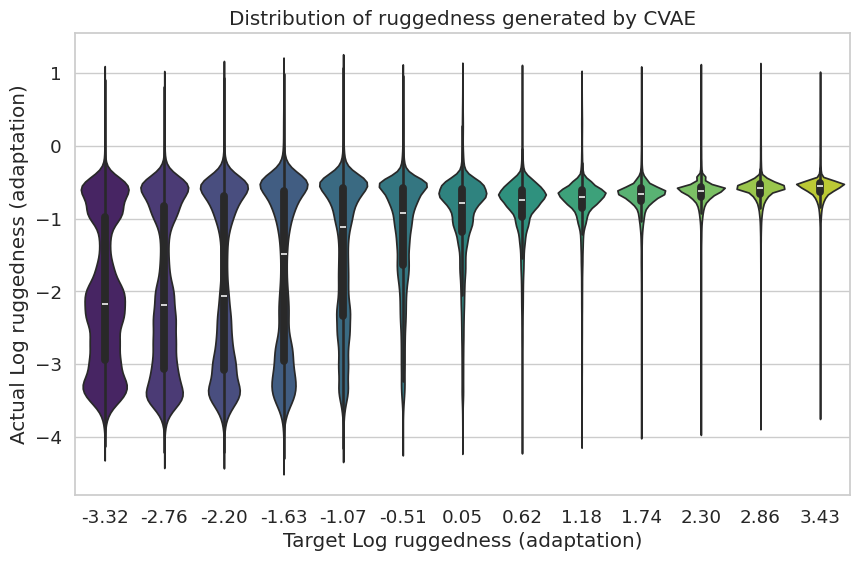

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x=sampled_rugg.flatten(), #[:len(ys_out)//all_fake_circuits.shape[1]].flatten(),
                    y=rugg_k[..., idx_output], palette='viridis')

plt.xlabel(f'Target {k_rugg}')
plt.xticks(ax.get_xticks(), [f'{i:.2f}' for i in np.unique(
    # sampled_rugg[:len(ys_out)//all_fake_circuits.shape[1]].flatten()).round(2)])
    sampled_rugg.flatten()).round(2)])
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_violin.png'),
            dpi=300, bbox_inches='tight', transparent=True)

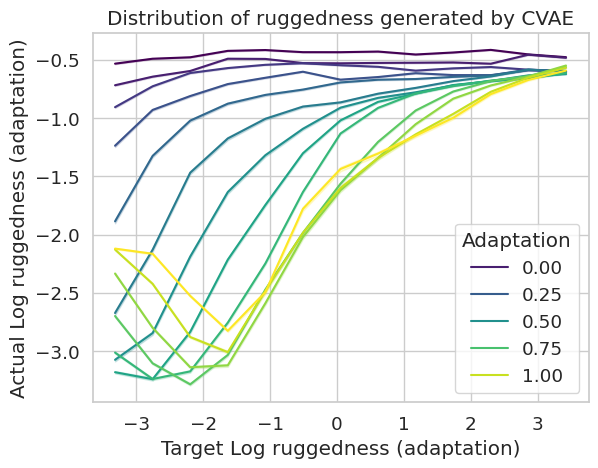

In [21]:
hue = all_sampled_cond[..., config_dataset.objective_col.index(
    'adaptation')].flatten()
df_plot = pd.DataFrame()
df_plot[f'Target {k_rugg}'] = sampled_rugg.flatten()
df_plot[f'Actual {k_rugg}'] = rugg_k[..., idx_output]
df_plot['Adaptation'] = all_sampled_cond[...,
                                         config_dataset.objective_col.index('adaptation')].flatten().round(2)
# plt.figure(figsize=(10, 6))
ax = sns.lineplot(df_plot, x=f'Target {k_rugg}', y=f'Actual {k_rugg}',
                  hue='Adaptation', palette='viridis')

plt.title('Distribution of ruggedness generated by CVAE')
plt.savefig(os.path.join(top_write_dir, 'ruggedness_lineplot.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [22]:
ys_out.shape

(10499125, 800, 1)

Text(0, 0.5, 'Signal')

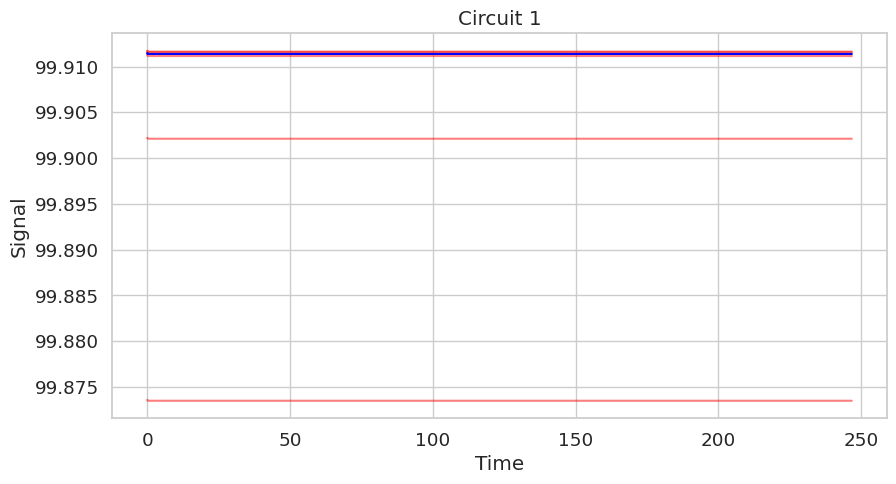

In [23]:
i = 0
i = i + 1
plt.figure(figsize=(10, 5))
for ii in range(n_perturbs):
    ti = len(ts) // 10
    is_og = ii == (n_perturbs - 1)
    plt.plot(ts[:ti], ys_out.reshape(-1, n_perturbs, *ys_out.shape[1:])[i, ii, :ti],
             color='b' if is_og else 'r',
             alpha=1 if is_og else 0.5)
plt.title(f'Circuit {i}')
plt.xlabel('Time')
plt.ylabel('Signal')


'1'

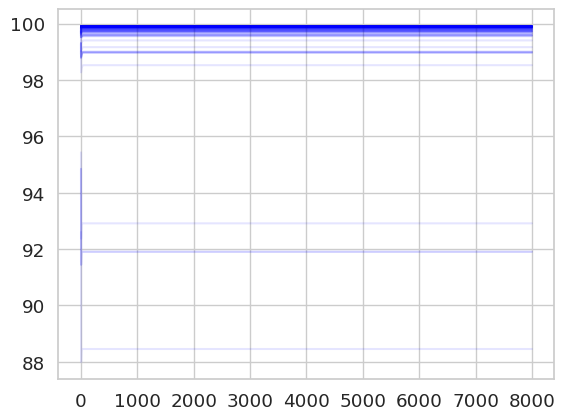

In [24]:
plt.plot(ts[:], ys_out[100:200, :, 0].T, alpha=0.1, color='b')
'1'
# stop

## Conditional plots

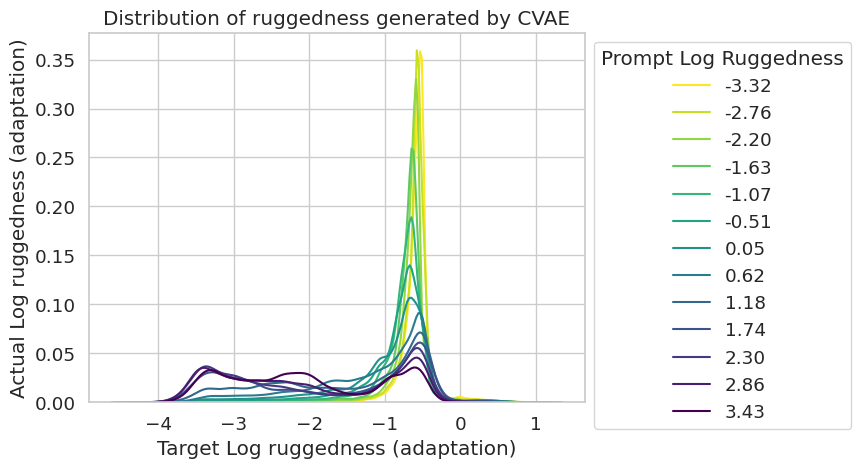

In [25]:
ax = sns.kdeplot(x=rugg_k[..., idx_output],
                 hue=sampled_rugg.flatten(), palette='viridis')

plt.xlabel(f'Target {k_rugg}')
plt.ylabel(f'Actual {k_rugg}')
plt.title('Distribution of ruggedness generated by CVAE')
leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
plt.legend(leg_text, title='Prompt Log Ruggedness')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(top_write_dir, 'ruggedness_kde.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [26]:
n_species = 3
output_species = ['RNA_2', 'RNA_3']
all_species = [str(i) for i in range(rugg_k.shape[-1] -
                                     n_species)] + ['RNA_1'] + output_species

vis_sampled_histplot(rugg_k, all_species, output_species, all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].reshape(-1, 1),  # c,
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                     hue_label='Prompt', figsize=(13, 5), output_idx=idx_output)

In [27]:
sampled_adapt = all_sampled_cond[...,
                                 config_dataset.objective_col.index('adaptation')]
idxs_adapt = np.where(sampled_adapt.flatten() >= 0.7 * sampled_adapt.max())
vis_sampled_histplot(rugg_k[idxs_adapt], all_species, output_species,
                     all_sampled_cond[..., config_dataset.objective_col.index(
                         k_rugg)].reshape(-1, 1)[idxs_adapt],
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg_hiadapt.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(sampled_rugg.flatten()),
                     hue_label='Prompt', figsize=(13, 5), output_idx=idx_output)

Now a KDE plot of ruggedness that's on a [0, 1] scale


In [28]:
norm_rugg_k = norm_rugg(
    rugg_k[idxs_adapt], df['Log ruggedness (adaptation)'].values, y_datanormaliser)

vis_sampled_histplot(norm_rugg_k, all_species, output_species,
                     all_sampled_cond[..., config_dataset.objective_col.index(
                         k_rugg)].reshape(-1, 1)[idxs_adapt],
                     title=f'Ruggedness of generated circuits', x_label=f'$Log_{{10}}$ Ruggedness', multiple='layer',
                     show=False, save_path=os.path.join(top_write_dir, 'kde_rugg_hiadapt2.png'),
                     f=sns.kdeplot, log_scale=[False, False], fill=False, include_hue_vlines=True, vline_uniqs=np.unique(all_sampled_cond[..., config_dataset.objective_col.index(k_rugg)].flatten()),
                     hue_label='Prompt', figsize=(13, 5), output_idx=idx_output)

# KDE + Training Data


In [29]:
# sns.set_context('notebook', font_scale=1.3)

# if len(config_dataset.objective_col) == 2:

#     k_other = 'adaptation'
#     k_other_idx = config_dataset.objective_col.index(k_other)
#     sampled_rev = y_datanormaliser.create_chain_preprocessor_inverse(
#         y_methods_preprocessing)(all_sampled_cond[..., k_other_idx], col=k_other)

#     uniq_sampled_other = np.array(sorted(np.unique(sampled_rev)))
#     uniq_sampled_other_half = uniq_sampled_other[::2]

#     filt_samp = data['sample_name'] == 'RNA_2'
#     binned_data_samples_other = np.array(list(map(lambda x: uniq_sampled_other_half[x], np.argmin(
#         np.abs(data[filt_samp][k_other].values[None, :] - uniq_sampled_other_half[:, None]), axis=0))))
#     binned_data_samples_rugg = np.array(list(map(lambda x: np.unique(sampled_rugg.flatten())[x], np.argmin(
#         np.abs(data[filt_samp][k_rugg].values[None, :] - np.unique(sampled_rugg.flatten())[:, None]), axis=0))))
#     rugg_k_rev = y_datanormaliser.create_chain_preprocessor(
#         y_methods_preprocessing)(rugg_k[..., idx_output], col=k_rugg, use_precomputed=True)
#     df_xbinned = pd.DataFrame()
#     df_xbinned[k_other] = binned_data_samples_other
#     df_xbinned[k_rugg] = data[filt_samp][k_rugg].values
#     df_xbinned[x_cols] = data[filt_samp][x_cols].values
#     df_xbinned[k_rugg + ' (normalized)'] = y_datanormaliser.create_chain_preprocessor(
#         y_methods_preprocessing)(df_xbinned[k_rugg].values, col=k_rugg, use_precomputed=True)

#     nrows = 2
#     ncols = len(uniq_sampled_other_half)

#     for inc, use_norm_cond in enumerate([True, False]):

#         if use_norm_cond:
#             x_plot = rugg_k_rev
#             hue = all_sampled_cond[..., config_dataset.objective_col.index(
#                 k_rugg)].flatten()
#             k_rugg_curr = k_rugg + ' (normalized)'
#         else:
#             x_plot = rugg_k[..., idx_output]
#             hue = sampled_rugg.flatten().round(1)
#             k_rugg_curr = k_rugg

#         leg_text = [f'{ii:.2f}' for ii in np.unique(sampled_rugg.flatten())]
#         fig, axs = plt.subplots(nrows, ncols, figsize=(
#             4*ncols, 3.5*nrows), sharex=True)  # , sharey=True)
#         for i, v0 in enumerate(uniq_sampled_other_half):
#             idxs_sampled0 = np.where(sampled_rev.flatten() == v0)[0]
#             g = sns.kdeplot(x=x_plot[idxs_sampled0],
#                             hue=hue[idxs_sampled0], palette='viridis', ax=axs.flat[i])
#             axs.flat[i].set_xlabel(f'{k_rugg_curr}')
#             if use_norm_cond:
#                 axs.flat[i].set_title(
#                     f'Prompt = {np.unique(all_sampled_cond[..., k_other_idx])[i*2]:.2f}')
#             else:
#                 axs.flat[i].set_title(
#                     f'Prompt = {v0:.1f}')
#             if i == (len(uniq_sampled_other_half) - 1):
#                 legend = g.legend_
#                 if legend:
#                     for text in legend.get_texts():
#                         text.set_text(f"{float(text.get_text()):.1f}")
#                 sns.move_legend(g, "upper left", bbox_to_anchor=(
#                     1, 1), title=f'Prompt $Log_{{10}}$\nRuggedness')
#             else:
#                 axs.flat[i].get_legend().remove()
#             axs[0, i].set_ylim(0, 3 if use_norm_cond else 0.6)
#             axs[0, i].set_ylabel('')
#         axs[0, 0].set_ylabel('Generated data density')

#         d = pd.melt(df_xbinned, id_vars=[
#                     k_other, k_rugg_curr], value_vars=x_cols, value_name='Input x', var_name='X type')
#         count_max = 1
#         for i, v0 in enumerate(uniq_sampled_other_half):
#             sns.histplot(d[d[k_other] == v0], x=k_rugg_curr, bins=30, ax=axs[1, i], log_scale=[
#                          False, True], element='step', fill=False)
#             # sns.histplot(d[d[k_other] == v0], x='adaptation', bins=30, ax=axs[1, i], log_scale=[False, True], element='step', fill=False)
#             count_max = np.max([count_max, d[d[k_other] == v0].shape[0]])
#             axs[1, i].set_ylabel('')
#             axs[1, i].set_xlabel(r'$Log_{10}$ ruggedness')
#         axs[1, 0].set_ylabel('Training data count')
#         for i in range(ncols):
#             axs[1, i].set_ylim(0, count_max)

#         plt.suptitle(
#             f'Distribution of ruggedness generated by CVAE, n={len(d)})')
#         plt.tight_layout()
#         plt.savefig(os.path.join(top_write_dir, f'ruggedness_by_prompt_{inc}.png'),
#                     dpi=300, bbox_inches='tight', transparent=True)

# Sensitivity vs. Precision

In [30]:
df_rugg = make_df_rugg(analytics_og, ruggedness, idx_output, all_sampled_cond, 
                 y_datanormaliser, y_methods_preprocessing, config_dataset, k_rugg)

for k in ['adaptation', 'Log ruggedness (adaptation)']:
    df_rugg[f'{k} norm'] = y_datanormaliser.create_chain_preprocessor(
        y_methods_preprocessing)(df_rugg[f'{k}'].values, col=k, use_precomputed=True)
    data[f'{k} norm'] = y_datanormaliser.create_chain_preprocessor(
        y_methods_preprocessing)(data[f'{k}'].values, col=k, use_precomputed=True)

data['Log ruggedness (adaptation) bin'] = pd.cut(
    data['Log ruggedness (adaptation)'], bins=10)
data['Log ruggedness (adaptation) bin'] = data['Log ruggedness (adaptation) bin'].apply(
    lambda x: x.mid).astype(float).round(2)


/workdir/notebooks/common.py:192: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:192: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))
/workdir/notebooks/common.py:192: RuntimeWarning: divide by zero encountered in log10
  ruggedness[col_rugg][..., idx_output] == 0, np.nan, np.log10(ruggedness[col_rugg][..., idx_output]))


In [31]:
idxs_show = make_sort_hue(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1]
                          ['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

# g = sns.jointplot(df_rugg[df_rugg['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show],
#                   x='Log sensitivity', y='Log precision',
#                   hue='Log ruggedness (adaptation) bin',
#                   alpha=0.5, palette='viridis')
# plt.xlabel(r'$Log_{10}$ sensitivity')
# plt.ylabel(r'$Log_{10}$ precision')
# l = plt.legend(title=r'$Log_{10}$ Ruggedness')
# for line in l.get_lines():
#     line.set(alpha=1.0)
# plt.savefig(os.path.join(top_write_dir, 'sp_jointplot.png'),
#             dpi=300, bbox_inches='tight', transparent=True)

In [32]:
# idxs_show = make_sort_hue(data[data['Log ruggedness (adaptation) bin'] > -1]
#                           ['Log ruggedness (adaptation) bin'].round(2), sort=True, sort_random=False, sort_flip_prop=4)

# sns.jointplot(data[data['Log ruggedness (adaptation) bin'] > -1].iloc[idxs_show],
#               x='Log sensitivity', y='Log precision',
#               hue='Log ruggedness (adaptation) bin',
#               alpha=0.5, palette='viridis')
# plt.xlabel(r'$Log_{10}$ sensitivity')
# plt.ylabel(r'$Log_{10}$ precision')
# plt.legend(title=r'$Log_{10}$ Ruggedness')
# plt.savefig(os.path.join(top_write_dir, 'sp_jointplot_training.png'),
#             dpi=300, bbox_inches='tight', transparent=True)

# Ruggedness vs. Adaptation

In [33]:
df_rugg['Is adaptable'] = False
df_rugg['Is adaptable og'] = False
df_rugg.loc[(df_rugg['Log sensitivity'] > 0) & (df_rugg['Log precision'] > 1),
            'Is adaptable og'] = True  # np.nanmax(df_rugg['Adaptation bin']) + 20
df_rugg.loc[df_rugg['adaptation'] > 870, 'Is adaptable'] = True

data['Is adaptable'] = False
data['Is adaptable og'] = False
data.loc[(data['Log sensitivity'] > 0) & (data['Log precision'] > 1),
         'Is adaptable og'] = True  # np.nanmax(data['Adaptation bin']) + 20
# np.nanmax(data['Adaptation bin']) + 20
data.loc[data['adaptation'] > 870, 'Is adaptable'] = True

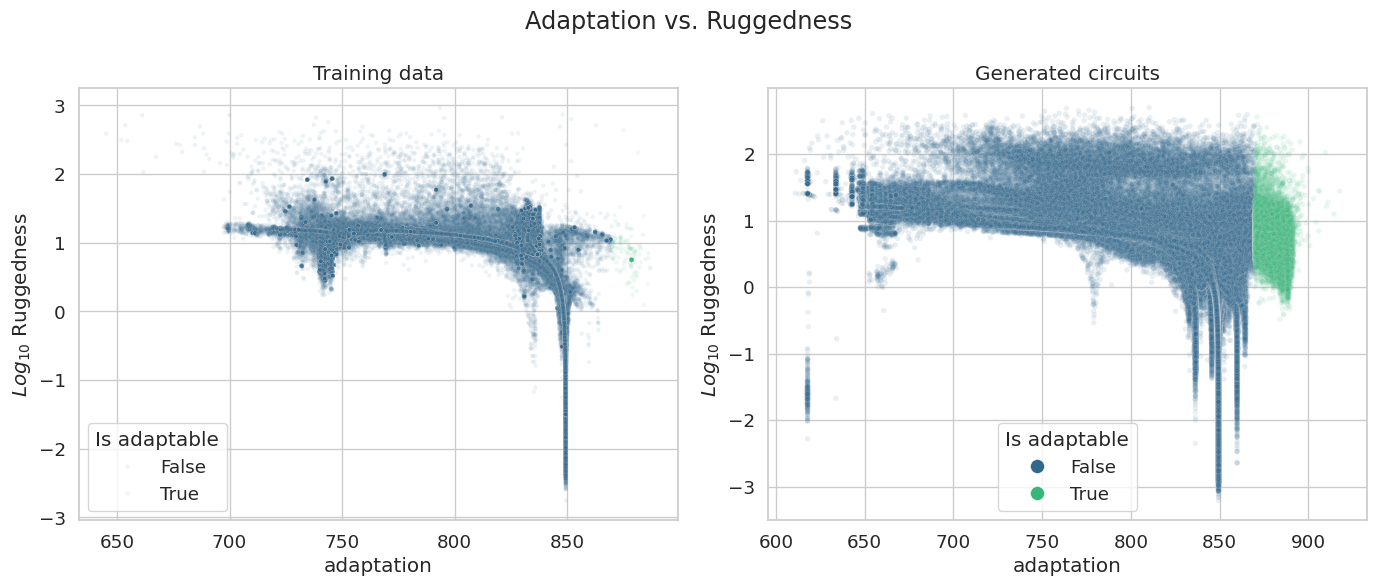

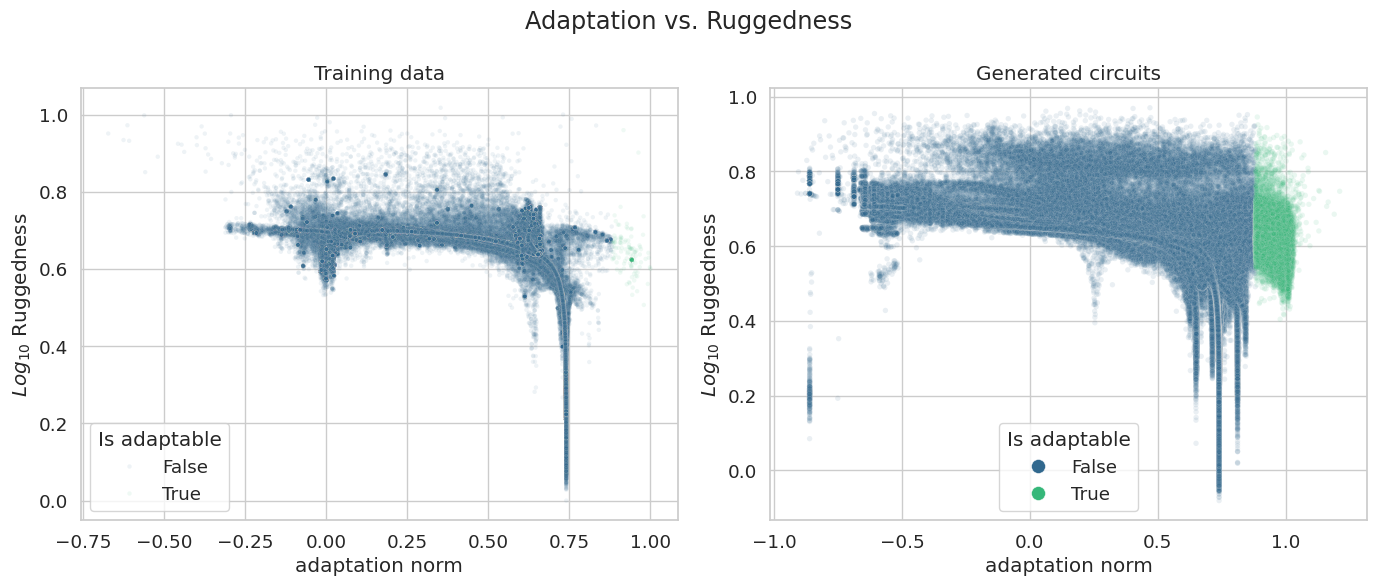

In [43]:
hue = 'initial_steady_states'
hue = 'steady_states'
hue = 'Is adaptable'
# hue = 'Is adaptable og'

sns.set_context('notebook', font_scale=1.2)

df_rugg['fold_change'] = analytics_og['fold_change'][..., idx_output]

for norm_setting in ['unnormalised', 'normalised']:
    if norm_setting == 'normalised':
        x_col = 'adaptation norm'
        y_col = 'Log ruggedness (adaptation) norm'
    else:
        x_col = 'adaptation'
        y_col = 'Log ruggedness (adaptation)'
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    g = sns.scatterplot(data[data['sample_name'] == 'RNA_2'].sort_values(by=hue).iloc[:1000000], x=x_col, y=y_col,
                        hue=hue, alpha=0.08,
                        palette='viridis', s=10, ax=axs[0], legend=True)
    axs[0].set_title('Training data')
    axs[0].set_ylabel(r'$Log_{10}$ Ruggedness')

    g = sns.scatterplot(df_rugg.sort_values(by=hue), x=x_col, y=y_col,
                        hue=hue, alpha=0.1,
                        palette='viridis', s=15, ax=axs[1])
    axs[1].set_title('Generated circuits')
    axs[1].set_ylabel(r'$Log_{10}$ Ruggedness')
    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title(hue)
    sns.move_legend(g, "lower center", title=hue)

    plt.suptitle('Adaptation vs. Ruggedness')
    plt.tight_layout()
    plt.savefig(os.path.join(
        top_write_dir, f'adaptation_ruggedness{"_norm" if norm_setting == "normalised" else ""}.png'), dpi=300, bbox_inches='tight', transparent=True)


/tmp/ipykernel_358683/2152779484.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


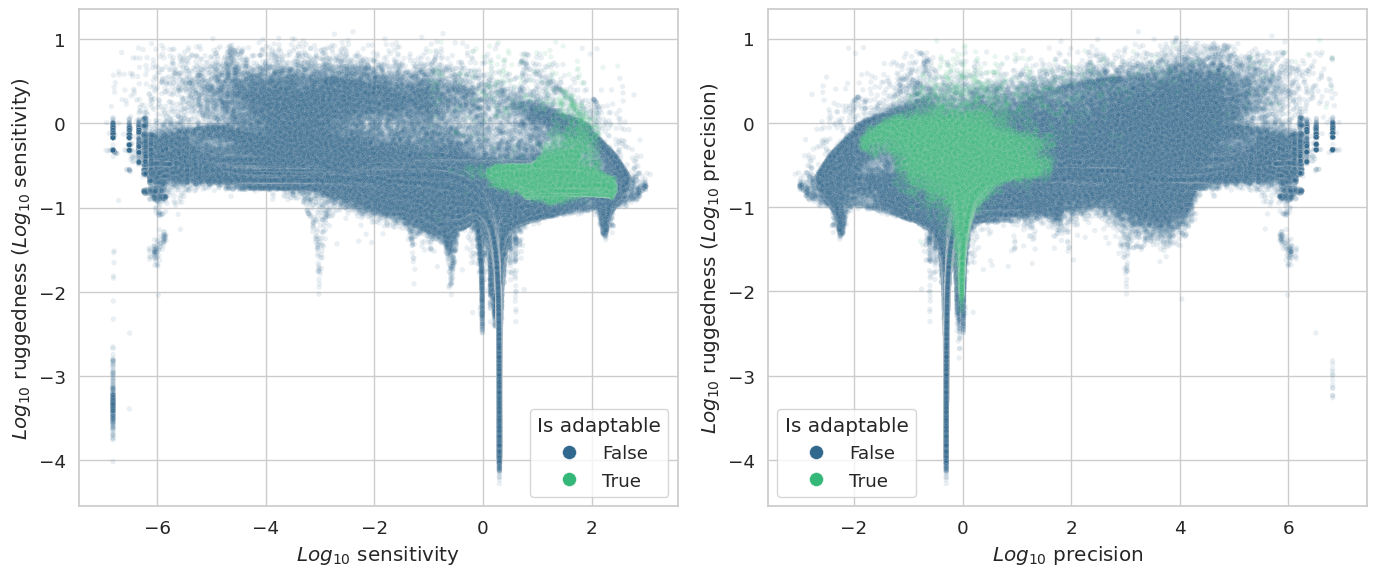

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, y_col in enumerate(['Log ruggedness (Log sensitivity)', 'Log ruggedness (Log precision)']):
    x_col = y_col.split('(')[-1].strip('()')
    g = sns.scatterplot(df_rugg.sort_values(by='Is adaptable'), x=x_col, y=y_col,
                        hue='Is adaptable', alpha=0.1,
                        palette='viridis', s=15, ax=axs[i], legend=True)

    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title('Is adaptable')
    # axs[i].set_title('Training data')
    axs[i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
    axs[i].set_ylabel(y_col.replace('Log', r'$Log_{10}$'))

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision.png'),
            dpi=300, bbox_inches='tight', transparent=True)

/tmp/ipykernel_358683/2676823370.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_358683/2676823370.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision_og.png'),
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


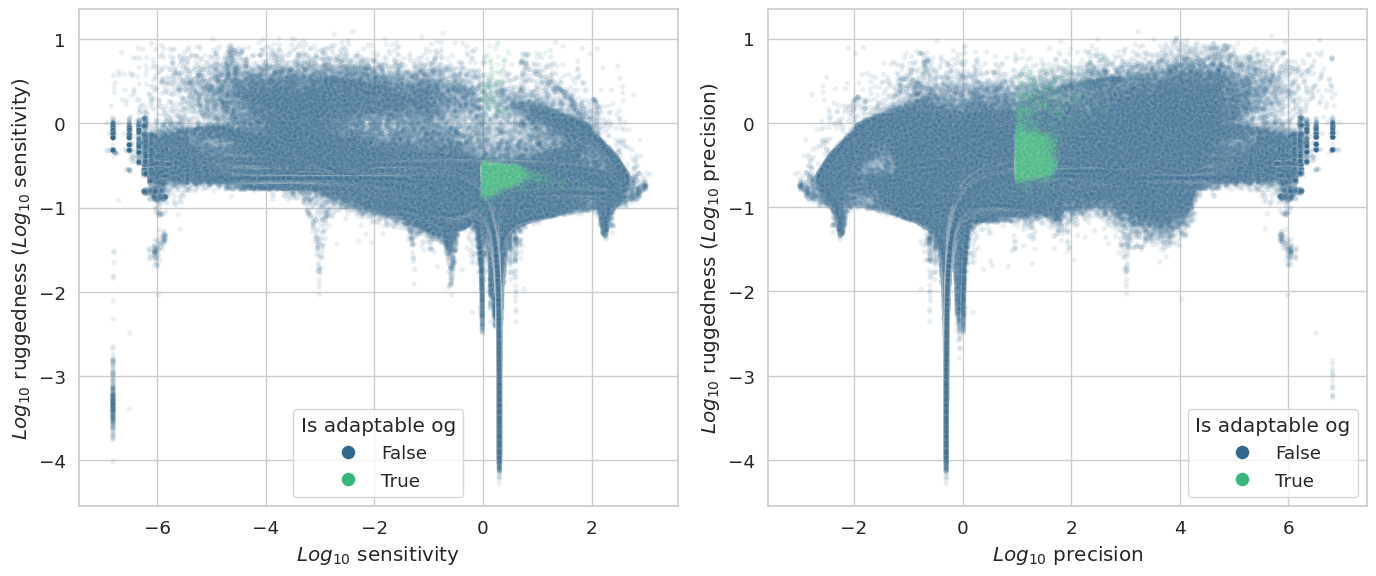

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
for i, y_col in enumerate(['Log ruggedness (Log sensitivity)', 'Log ruggedness (Log precision)']):
    x_col = y_col.split('(')[-1].strip('()')
    g = sns.scatterplot(df_rugg.sort_values(by='Is adaptable og'), x=x_col, y=y_col,
                        hue='Is adaptable og', alpha=0.1,
                        palette='viridis', s=15, ax=axs[i], legend=True)

    for line in g.legend().get_lines():
        line.set(alpha=1.0, markersize=10)
    g.legend_.set_title('Is adaptable og')
    # axs[i].set_title('Training data')
    axs[i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
    axs[i].set_ylabel(y_col.replace('Log', r'$Log_{10}$'))

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision_og.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Investigate long tail

In [37]:
cols_e = [r'$k_{' + str(i) + str(j) + '}$' for i, j in sorted(set([tuple(sorted(i))
                                                                   for i in itertools.product(np.arange(n_species) + 1, np.arange(n_species) + 1)]))]
data = data.rename(columns=dict(
    zip(sorted([c for c in data.columns if c.startswith('energies')]), cols_e)))

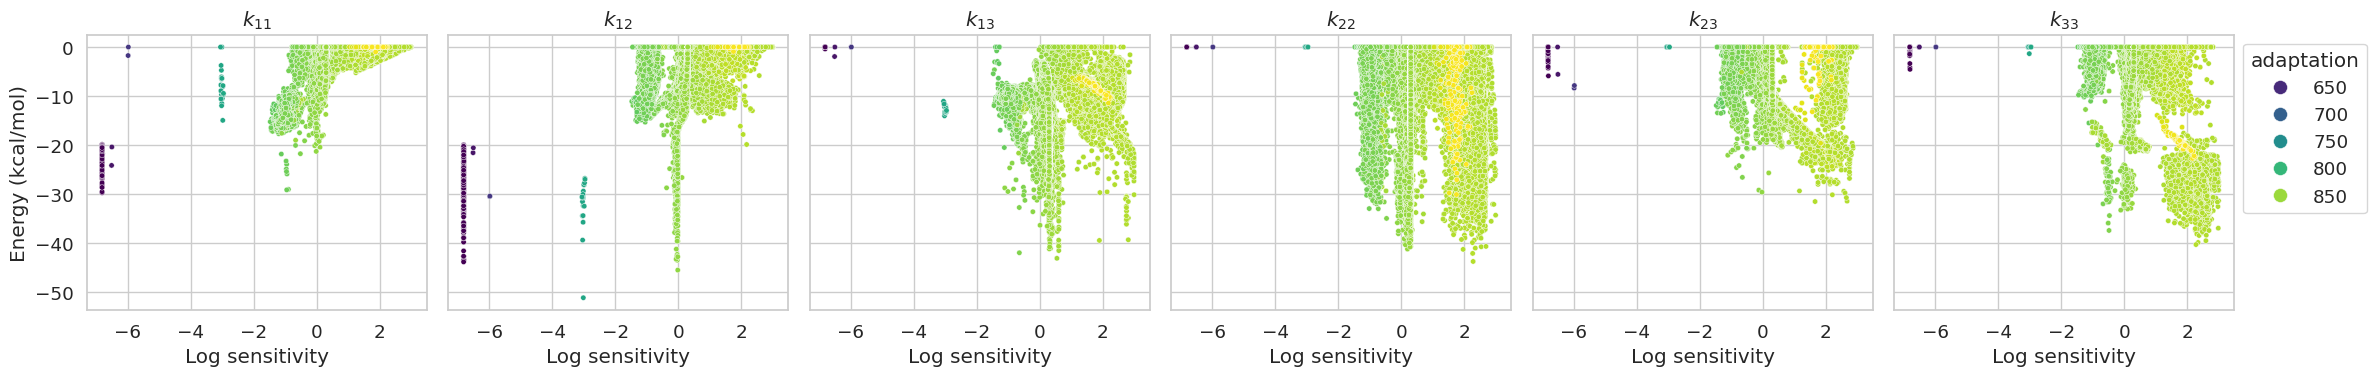

In [38]:
idx_perturbations_og = -1
assert all_fake_circuits.ndim == 4, 'Expected all_fake_circuits to be 4D: (n_samples, n_perturbs, n_species, n_species)'
df_rugg[cols_e] = make_sequence_from_symmetrical(all_fake_circuits[:, idx_perturbations_og, ...], side_length=n_species)

fig, axs = plt.subplots(1, len(cols_e), figsize=(4*len(cols_e), 4), sharey=True, sharex=True)
hue = 'adaptation'
x_col = 'Log ruggedness (Log sensitivity)'
x_col = 'Log sensitivity'

filt = (df_rugg['Log ruggedness (Log sensitivity)'] < -1) & (
        df_rugg['Log ruggedness (Log precision)'] < -1)
filt = (df_rugg['Log ruggedness (adaptation)'] < 0)
for i, y_col in enumerate(cols_e):
    g = sns.scatterplot(df_rugg[filt].sort_values(by='Is adaptable'), x=x_col,
        y=y_col, hue=hue,
        palette='viridis', s=15, ax=axs[i], legend=i == (len(cols_e) - 1))
    # g = sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (
    #     data['Log ruggedness (Log sensitivity)'] < -2) & (
    #     data['Log ruggedness (Log precision)'] < -2)].sort_values(by='Is adaptable'), x=x_col,
    #     y=y_col, hue=x_col,
    #     palette='viridis', s=15, ax=axs[i], legend=i == (len(cols_e) - 1))
    
    if i == (len(cols_e) - 1):
        for line in g.legend().get_lines():
            line.set(alpha=1.0, markersize=10)
        g.legend_.set_title(hue)
        sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    # axs[i].set_xlabel(x_col.replace('Log', r'$Log_{10}$'))
    if i == 0: axs[i].set_ylabel('Energy (kcal/mol)')
    axs[i].set_title(y_col)

plt.tight_layout()
# plt.savefig(os.path.join(top_write_dir, 'ruggedness_sensitivity_precision.png'), dpi=300, bbox_inches='tight', transparent=True)

In [39]:
# ys_out.reshape(n_samples, n_perturbs, ys_out.shape[-2], ys_out.shape[-1]).shape
filt = df_rugg[df_rugg['Log ruggedness (adaptation)'] < 0].index.to_numpy()
assert ys_out.ndim == 3, 'Expected ys_out to be 3D: (n_samples, time_steps, species out)'
ys_p = ys_out.reshape(n_samples, n_perturbs, *ys_out.shape[1:])[
    filt][:, idx_perturbations_og, ...].reshape(-1, *ys_out.shape[1:])


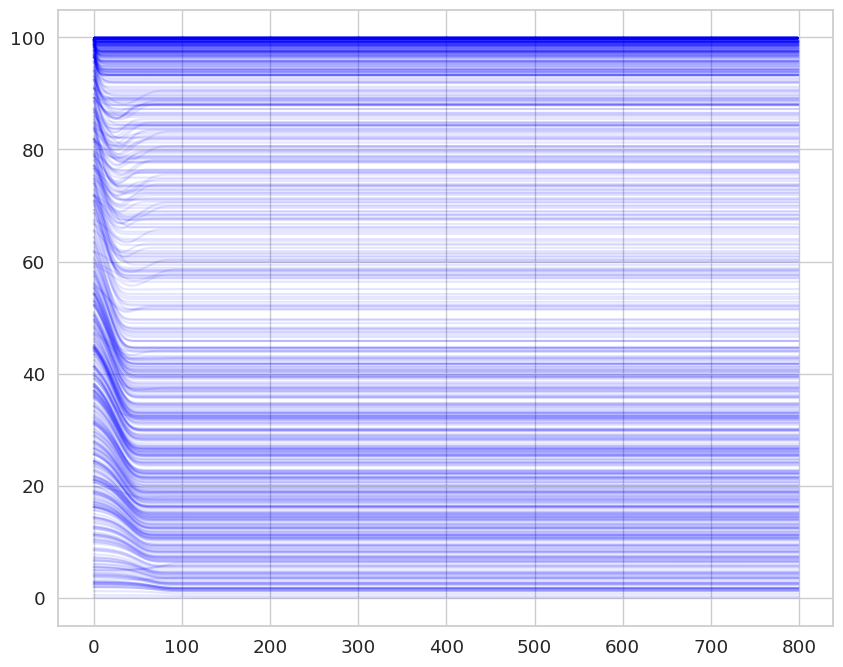

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(800):
    sns.lineplot(ys_p[i, :, -1], legend=False, alpha=0.1, color='b')

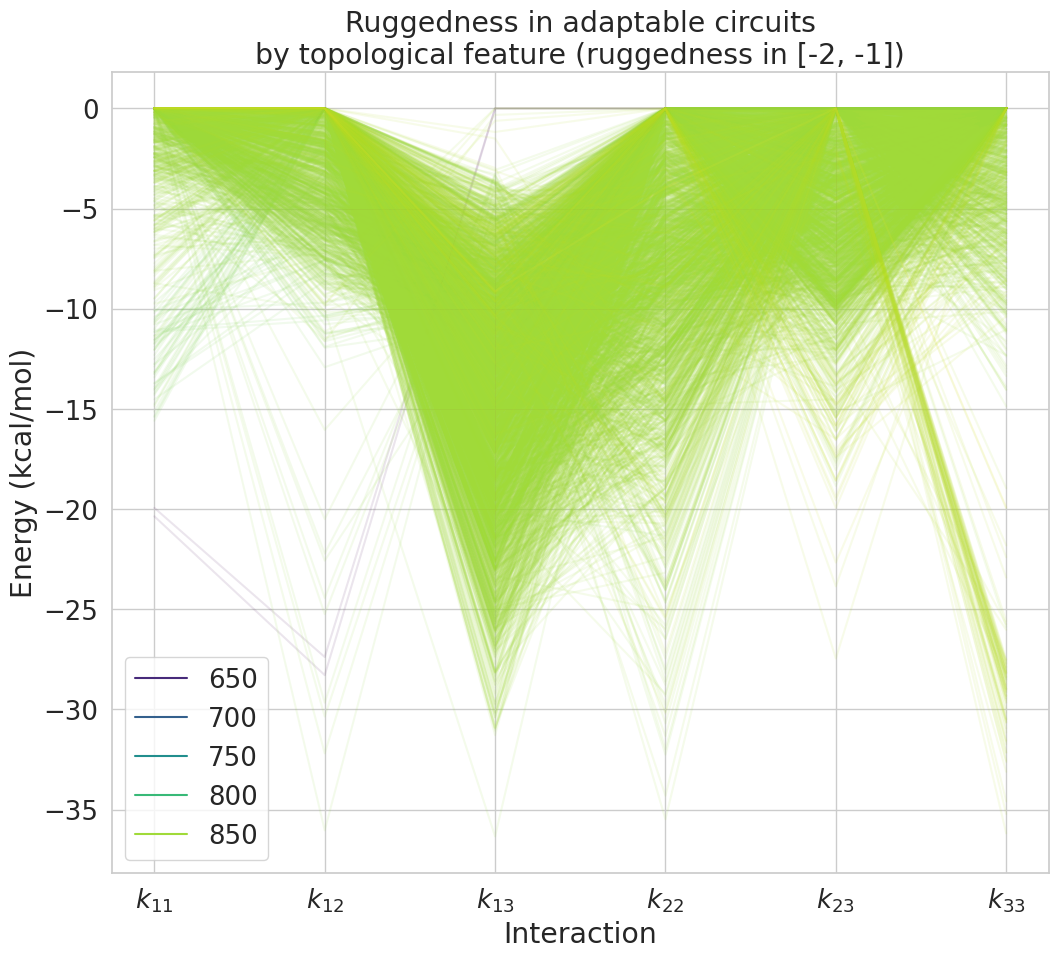

In [42]:
sns.set_context("notebook", font_scale=1.7)

n_show = int(1e4)
range_rugg_btwn = [-2, -1]
# dfm = data[(data['Log ruggedness (adaptation)'].between(*range_rugg_btwn)) & (data['sample_name'] == 'RNA_2')].melt(
filt = (df_rugg['Log ruggedness (adaptation)'] < 0) & (df_rugg.index.isin(np.array(
    jax.random.choice(jax.random.PRNGKey(0), np.arange(len(df_rugg)), shape=(n_show,), replace=False))))
dfm = df_rugg[filt].reset_index(drop=False).melt(
    id_vars=['index',
             'adaptation',
             'Log ruggedness (adaptation)',
             'Log ruggedness (adaptation) norm'],
    value_vars=cols_e, value_name='Energy (kcal/mol)', var_name='Interaction name').sort_values('Interaction name')
dfm['Interaction'] = dfm['Interaction name'].apply(
    lambda x: dict(zip(cols_e, np.arange(len(cols_e))))[x])

plt.figure(figsize=(11, 10))
hue = 'adaptation'
g = sns.lineplot(dfm.sort_values(by=hue, ascending=True),
                 x='Interaction', y='Energy (kcal/mol)',
                 #  hue='Log ruggedness (adaptation)', alpha=0.5,
                 hue=hue, alpha=0.1,
                 units='index', estimator=None,
                 palette='viridis')
for line in g.legend().get_lines():
    line.set(alpha=1.0, markersize=15)
# g.legend_.set_title(f'$Log_{{10}}$ Ruggedness')
plt.xticks(np.arange(len(cols_e)), cols_e)  # , rotation=45)

plt.title(
    f'Ruggedness in adaptable circuits\nby topological feature (ruggedness in {range_rugg_btwn})')
plt.tight_layout()